In [ ]:
import glob
import os

import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import warnings
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter,FuncFormatter
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Lables of the category data

In [3]:
# Value Label
# Customer subtype
L0_dict = {
    1: "High Income, expensive child",
    2: "Very Important Provincials",
    3: "High status seniors",
    4: "Affluent senior apartments",
    5: "Mixed seniors",
    6: "Career and childcare",
    7: "Dinki's (double income no kids)",
    8: "Middle class families",
    9: "Modern, complete families",
    10: "Stable family",
    11: "Family starters",
    12: "Affluent young families",
    13: "Young all american family",
    14: "Junior cosmopolitan",
    15: "Senior cosmopolitans",
    16: "Students in apartments",
    17: "Fresh masters in the city",
    18: "Single youth",
    19: "Suburban youth",
    20: "Etnically diverse",
    21: "Young urban have-nots",
    22: "Mixed apartment dwellers",
    23: "Young and rising",
    24: "Young, low educated ",
    25: "Young seniors in the city",
    26: "Own home elderly",
    27: "Seniors in apartments",
    28: "Residential elderly",
    29: "Porchless seniors: no front yard",
    30: "Religious elderly singles",
    31: "Low income catholics",
    32: "Mixed seniors",
    33: "Lower class large families",
    34: "Large family, employed child",
    35: "Village families",
    36: "Couples with teens Married with children",
    37: "Mixed small town dwellers",
    38: "Traditional families",
    39: "Large religous families",
    40: "Large family farms",
    41: "Mixed rurals"
}

# average age keys
L1_dict = {
    1: "20-30 years",
    2: "30-40 years",
    3: "40-50 years",
    4: "50-60 years",
    5: "60-70 years",
    6: "70-80 years"
}

# customer main type keys:
L2_dict = {

    1: "Successful hedonists",
    2: "Driven Growers",
    3: "Average Family",
    4: "Career Loners",
    5: "Living well",
    6: "Cruising Seniors",
    7: "Retired and Religeous",
    8: "Family with grown ups",
    9: "Conservative families",
    10: "Farmers"
}

# percentage keys:
L3_dict = {
    0: "0%",
    1: "1 - 10%",
    2: "11 - 23%",
    3: "24 - 36%",
    4: "37 - 49%",
    5: "50 - 62%",
    6: "63 - 75%",
    7: "76 - 88%",
    8: "89 - 99%",
    9: "100% :"
}

# total number keys
L4_dict = {
    0: "0",
    1: "1 - 49",
    2: "50 - 99",
    3: "100 - 199",
    4: "200 - 499",
    5: "500 - 999",
    6: "1000 - 4999",
    7: "5000 - 9999",
    8: "10,000 - 19,999",
    9: ">= 20,000"

}
# Nr Name Description Domain
data_list = [
    [1, "MOSTYPE", "Customer Subtype"],  # see L0
    [2, "MAANTHUI", "Number of houses"],  # 1 – 10
    [3, "MGEMOMV", "Avg size household"],  # 1 – 6
    [4, "MGEMLEEF", "Avg age"],  # see L1
    [5, "MOSHOOFD", "Customer main type"],  # see L2
    [6, "MGODRK", "Roman catholic"],  # see L3
    [7, "MGODPR", "Protestant"],
    [8, "MGODOV", "Other religion"],
    [9, "MGODGE", "No religion"],
    [10, "MRELGE", "Married"],
    [11, "MRELSA", "Living together"],
    [12, "MRELOV", "Other relation"],
    [13, "MFALLEEN", "Singles"],
    [14, "MFGEKIND", "Household without children"],
    [15, "MFWEKIND", "Household with children"],
    [16, "MOPLHOOG", "High level education"],
    [17, "MOPLMIDD", "Medium level education"],
    [18, "MOPLLAAG", "Lower level education"],
    [19, "MBERHOOG", "High status"],
    [20, "MBERZELF", "Entrepreneur"],
    [21, "MBERBOER", "Farmer"],
    [22, "MBERMIDD", "Middle management"],
    [23, "MBERARBG", "Skilled labourers"],
    [24, "MBERARBO", "Unskilled labourers"],
    [25, "MSKA", "Social class A"],
    [26, "MSKB1", "Social class B1"],
    [27, "MSKB2", "Social class B2"],
    [28, "MSKC", "Social class C"],
    [29, "MSKD", "Social class D"],
    [30, "MHHUUR", "Rented house"],
    [31, "MHKOOP", "Home owners"],
    [32, "MAUT1", "1 car"],
    [33, "MAUT2", "2 cars"],
    [34, "MAUT0", "No car"],
    [35, "MZFONDS", "National Health Service"],
    [36, "MZPART", "Private health insurance"],
    [37, "MINKM30", "Income < 30.000"],
    [38, "MINK3045", "Income 30-45.000"],
    [39, "MINK4575", "Income 45-75.000"],
    [40, "MINK7512", "Income 75-122.000"],
    [41, "MINK123M", "Income >123.000"],
    [42, "MINKGEM", "Average income"],
    [43, "MKOOPKLA", "Purchasing power class"],
    [44, "PWAPART", "Contribution private third party insurance see"],  # L4
    [45, "PWABEDR", "Contribution third party insurance (firms)"],
    [46, "PWALAND", "Contribution third party insurane (agriculture)"],
    [47, "PPERSAUT", "Contribution car policies"],
    [48, "PBESAUT", "Contribution delivery van policies"],
    [49, "PMOTSCO", "Contribution motorcycle/scooter policies"],
    [50, "PVRAAUT", "Contribution lorry policies"],
    [51, "PAANHANG", "Contribution trailer policies"],
    [52, "PTRACTOR", "Contribution tractor policies"],
    [53, "PWERKT", "Contribution agricultural machines policies"],
    [54, "PBROM", "Contribution moped policies"],
    [55, "PLEVEN", "Contribution life insurances"],
    [56, "PPERSONG", "Contribution private accident insurance policies"],
    [57, "PGEZONG", "Contribution family accidents insurance policies"],
    [58, "PWAOREG", "Contribution disability insurance policies"],
    [59, "PBRAND", "Contribution fire policies"],
    [60, "PZEILPL", "Contribution surfboard policies"],
    [61, "PPLEZIER", "Contribution boat policies"],
    [62, "PFIETS", "Contribution bicycle policies"],
    [63, "PINBOED", "Contribution property insurance policies"],
    [64, "PBYSTAND", "Contribution social security insurance policies"],
    [65, "AWAPART", "Number of private third party insurance 1 - 12"],
    [66, "AWABEDR", "Number of third party insurance (firms)"],
    [67, "AWALAND", "Number of third party insurane (agriculture)"],
    [68, "APERSAUT", "Number of car policies"],
    [69, "ABESAUT", "Number of delivery van policies"],
    [70, "AMOTSCO", "Number of motorcycle/scooter policies"],
    [71, "AVRAAUT", "Number of lorry policies"],
    [72, "AAANHANG", "Number of trailer policies"],
    [73, "ATRACTOR", "Number of tractor policies"],
    [74, "AWERKT", "Number of agricultural machines policies"],
    [75, "ABROM", "Number of moped policies"],
    [76, "ALEVEN", "Number of life insurances"],
    [77, "APERSONG", "Number of private accident insurance policies"],
    [78, "AGEZONG", "Number of family accidents insurance policies"],
    [79, "AWAOREG", "Number of disability insurance policies"],
    [80, "ABRAND", "Number of fire policies"],
    [81, "AZEILPL", "Number of surfboard policies"],
    [82, "APLEZIER", "Number of boat policies"],
    [83, "AFIETS", "Number of bicycle policies"],
    [84, "AINBOED", "Number of property insurance policies"],
    [85, "ABYSTAND", "Number of social security insurance policies"],
    [86, "CARAVAN", "Number of mobile home policies 0 - 1"]
]


### Utility Function

In [4]:
# class CaravanInsurance:

# def __init__(self):
#     self.train_data = np.array([])
#     self.test_data = np.array([])
#     self.train_df = pd.DataFrame([])

def read_data(file_list):
    """
    This method is responsible for reading the data from
    file and store into variables as an array
    :param file_list:
    :return: None
    """
    info_file = file_list[0]
    test_file = file_list[1]
    train_file = file_list[2]

    text_file = open(info_file, "r")
    lines = text_file.read()

    train_data = np.loadtxt(train_file, dtype=int)
    test_data = np.loadtxt(test_file, dtype=int)
    return train_data,test_data

def construct_df(data_list, columns):
    """
    This method is responsible for making a numpy array
    to pandas data frame which will be useful for performing
    various operations.
    :param data_list:
    :param columns:
    :return:
    """
    if isinstance(data_list, np.ndarray):
        data_list = data_list.tolist()

    train_df = pd.DataFrame(data=data_list, columns=columns)

    return train_df

def check_data_consistency(train_data):
    """
    This method is responsible for checking the data consistency.
    Data Consistency is done based on whether the column value
    consists of L0,L1 etc. values and is there any nan value exists
    or not.
    :param train_data:
    :return: None
    """
    print("Data Consistency Check.....")
    # Check first column values only L0 specified values
    l0_arr = np.array(list(L0_dict.keys()))
    l1_arr = np.array(list(L1_dict.keys()))
    l2_arr = np.array(list(L2_dict.keys()))
    l3_arr = np.array(list(L3_dict.keys()))
    l4_arr = np.array(list(L4_dict.keys()))

    data = train_data[:, :-1]
    ln = data.shape[1]
    mask = None
    for idx in tqdm(range(ln)):
        arr = data[:, idx]
        if idx == 0:
            mask = np.isin(arr, l0_arr)
        elif idx == 1:
            mask = np.isin(arr, np.arange(1, 11, 1))
        elif idx == 2:
            mask = np.isin(arr, np.arange(1, 7, 1))
        elif idx == 3:
            mask = np.isin(arr, l1_arr)
        elif idx == 4:
            mask = np.isin(arr, l2_arr)
        elif 5 <= idx <= 42:
            mask = np.isin(arr, l3_arr)
        elif 43 <= idx <= 84:
            mask = np.isin(arr, l4_arr)
        if not mask.all() or np.isnan(arr).any():
            print("In column {} exists invalid value".format(idx))
            
def plot_confusion_matrix(cm):
    """
    This method is responsible for 
    plotting the confusion matrix.
    """
    tick_list = ['purchased (1)', 'not purchased (0)']
    ax = plt.subplot()
    sns.heatmap(cm,annot=True,fmt='g',ax=ax)
    ax.set_xlabel('Predicted labels');
    ax.xaxis.set_label_position('top') 
    ax.xaxis.set_tick_params(labeltop='on',labelbottom = False,)
    ax.set_ylabel('Actual labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(tick_list); 
    ax.yaxis.set_ticklabels(tick_list);
    plt.show()
            
def plot_roc_curve(title,fpr,tpr):
    """
    This method is responsible for plotting the 
    Receiver Opertaing Characteristic curve.
    """
    var_auc = auc(fpr, tpr)
    fig = plt.figure(figsize=(12,7))
    ax1 = fig.add_subplot(111)
    ax1.fill_between(fpr, tpr, 0, color='steelblue', alpha=0.6)
    ax1 = plt.plot(fpr, tpr, linewidth=3, label=title+'; AUC = %0.2f' % var_auc)
    plt.legend(loc='upper left')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title, size=14)
    plt.show()

def column_selection(df):        
    corr = df.corr()
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= 0.9:
                if columns[j]:
                    columns[j] = False
    selected_columns = df.columns[columns]
    return df[selected_columns]

def plot_heatmap(corr):
    fig,ax = plt.subplots(figsize=(50,20))
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    sns.heatmap(
        corr, 
        ax=ax,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )

    plt.show()

### Reading the train, test and meta data

In [5]:
#List all data files
file_list = glob.glob("C:/Users/USER/Documents/ML/insurance/data/*")#.format(project_root))

# Read from Train and Test Files as numpy array....
train_data,test_data = read_data(file_list)

# Checking the data consistensy
check_data_consistency(train_data)

# Make Data Frame, Readibng the column names from list
columns = [i[1] for i in data_list]

# Prepare the Data Frame for Training Data
caravan_df = construct_df(train_data, columns)
# corr = caravan_df.corr()

Data Consistency Check.....


100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 9472.23it/s]


In [6]:
# Get a liitle idea about the dimension of our data
caravan_df.shape

(5822, 86)

In [7]:
# Sample Data
caravan_df.head()

MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  MGODOV  \
0       33         1        3         2         8       0       5       1   
1       37         1        2         2         8       1       4       1   
2       37         1        2         2         8       0       4       2   
3        9         1        3         3         3       2       3       2   
4       40         1        4         2        10       1       4       1   

   MGODGE  MRELGE   ...     APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  \
0       3       7   ...            0        0        0       1        0   
1       4       6   ...            0        0        0       1        0   
2       4       3   ...            0        0        0       1        0   
3       4       5   ...            0        0        0       1        0   
4       4       7   ...            0        0        0       1        0   

   APLEZIER  AFIETS  AINBOED  ABYSTAND  CARAVAN  
0         0       0        0         0        0  
1         0       0        0         0        0  
2         0       0        0         0        0  
3         0       0        0         0        0  
4         0       0        0         0        0  

[5 rows x 86 columns]

In [8]:
#List of all columns
# In this data set our target variable is 'CARAVAN' which has two values 0 and 1
caravan_df.columns

Index(['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK',
       'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN',
       'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG',
       'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA',
       'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2',
       'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575',
       'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART', 'PWABEDR',
       'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG',
       'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG',
       'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED',
       'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT',
       'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM',
       'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL',
       'APLEZIER', 'AFIETS',

### Imabalance Dataset

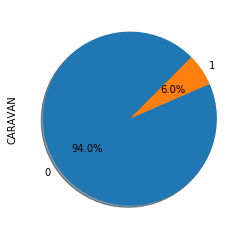

In [10]:
#Plotting the target value ratio in pie chart
caravan_df.CARAVAN.value_counts().plot.pie(autopct='%1.1f%%',shadow=True,startangle=45)

### Data Analysis

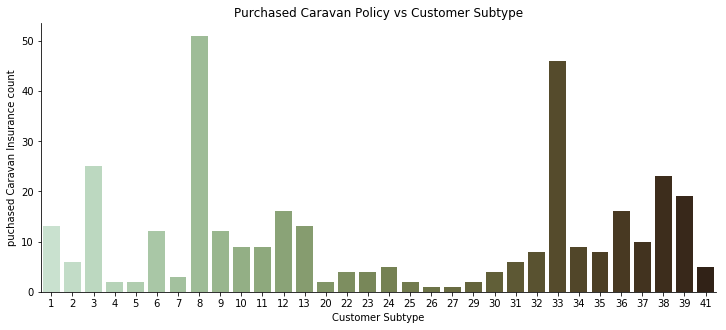

In [11]:
#Exploring variables
# Purchased Caravan Policy vs Customer Subtype
cust_sub = list(L0_dict.values())
purchased_df = caravan_df.loc[caravan_df.CARAVAN == 1]
customer_subtype = purchased_df.loc[:,"MOSTYPE"]
# customer_subtype = customer_subtype.apply(lambda x: cust_sub[x-1])
ax=sns.catplot(x=customer_subtype.index,data=customer_subtype,kind = "count",palette="ch:25",aspect=2)
ax.set(xlabel="Customer Subtype",ylabel="puchased Caravan Insurance count",title="Purchased Caravan Policy vs Customer Subtype")
plt.show()
# From the figure we can see that the moajority of people who agreed to buy the insurance were Medium class families and 
# Lower class large families"

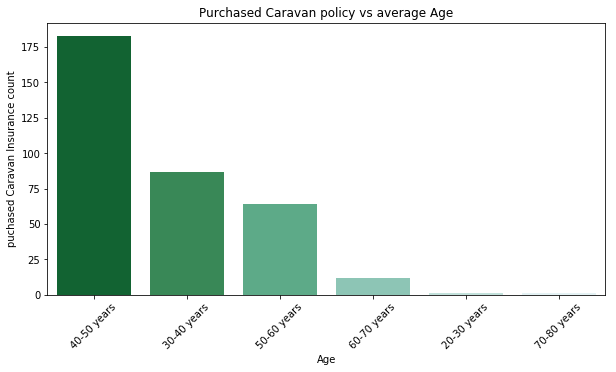

In [12]:
#Purchased Caravan policy vs average Age
age_class_label = list(L1_dict.values())
purchased_df = caravan_df.loc[caravan_df.CARAVAN == 1]
age_classes =purchased_df.loc[:,"MGEMLEEF"]
age_classes = age_classes.apply(lambda x: age_class_label[x-1])
plt.figure(figsize=(10,5))
ax = sns.countplot(x=age_classes.index,data=age_classes,palette=sns.color_palette("BuGn_r"))
ax.set(title="Purchased Caravan policy vs average Age",xlabel = "Age", ylabel="puchased Caravan Insurance count")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

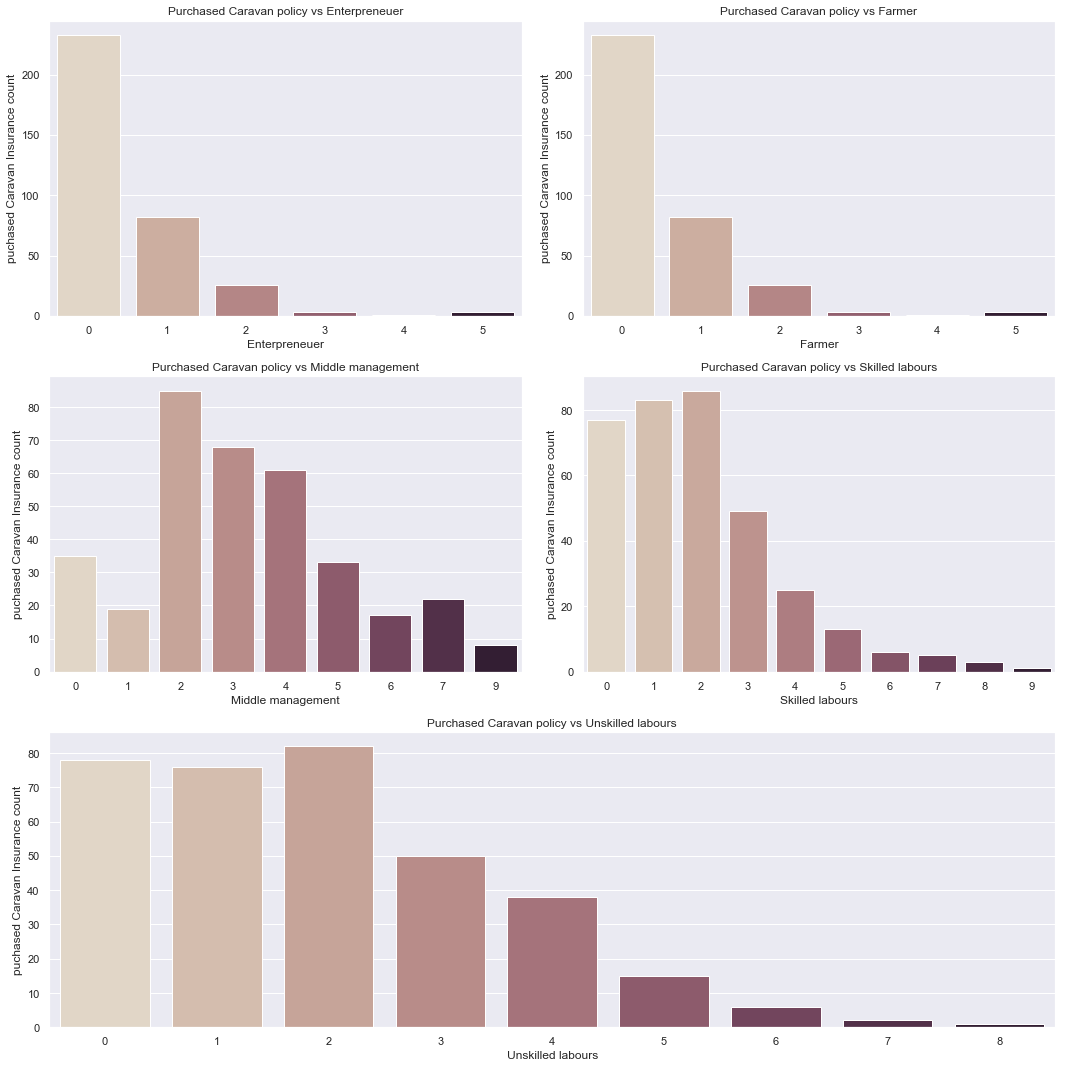

In [13]:
#Purchased Caravan policy vs work

# [20, "MBERZELF", "Entrepreneur"],
# [21, "MBERBOER", "Farmer"],
# [22, "MBERMIDD", "Middle management"],
# [23, "MBERARBG", "Skilled labourers"],
# [24, "MBERARBO", "Unskilled labourers"]

purchased_df = caravan_df.loc[caravan_df.CARAVAN == 1]
enterpreneuer = purchased_df.loc[:,"MBERZELF"]
farmer = purchased_df.loc[:,"MBERZELF"]
middle_management = purchased_df.loc[:,"MBERMIDD"]
skilled_labours = purchased_df.loc[:,"MBERARBG"]
unskilled_labours = purchased_df.loc[:,"MBERARBO"]

gs = gridspec.GridSpec(3, 2)
plt.figure(figsize=(15,15))
sns.set(style="darkgrid")

ax = plt.subplot(gs[0,0])
sns.countplot(x=enterpreneuer.index,data=enterpreneuer,palette="ch:.25",ax=ax)
ax.set(title="Purchased Caravan policy vs Enterpreneuer",xlabel = "Enterpreneuer", ylabel="puchased Caravan Insurance count")

ax1 = plt.subplot(gs[0,1])
sns.countplot(x=farmer.index,data=farmer,palette="ch:.25",ax=ax1)
ax1.set(title="Purchased Caravan policy vs Farmer",xlabel = "Farmer", ylabel="puchased Caravan Insurance count")

ax2 = plt.subplot(gs[1,0])
sns.countplot(x=middle_management.index,data=middle_management,palette="ch:.25",ax=ax2)
ax2.set(title="Purchased Caravan policy vs Middle management",xlabel = "Middle management", ylabel="puchased Caravan Insurance count")

ax3 = plt.subplot(gs[1,1])
sns.countplot(x=skilled_labours.index,data=skilled_labours,palette="ch:.25",ax=ax3)
ax3.set(title="Purchased Caravan policy vs Skilled labours",xlabel = "Skilled labours", ylabel="puchased Caravan Insurance count")

ax4 = plt.subplot(gs[2,:])
sns.countplot(x=unskilled_labours.index,data=unskilled_labours,palette="ch:.25",ax=ax4)
ax4.set(title="Purchased Caravan policy vs Unskilled labours",xlabel = "Unskilled labours", ylabel="puchased Caravan Insurance count")

plt.tight_layout()
plt.show()

# We can see that the majority of labours are qualified (less than 36% of unskilled labourers) with less than 20% entreprenors ,
# and most of them live in the city ( since they are not farmers ),less than 50% are unskilled labourers

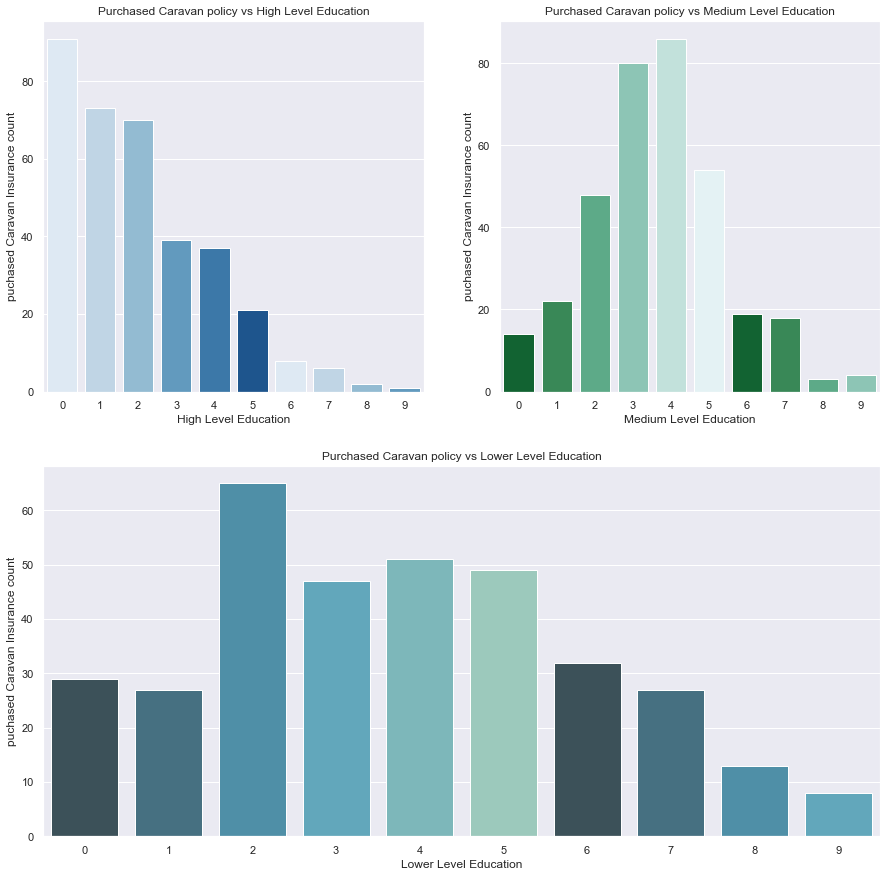

In [14]:
#Purchased Caravan policy vs Education
#[16, "MOPLHOOG", "High level education"]
#[17, "MOPLMIDD", "Medium level education"]
#[18, "MOPLLAAG", "Lower level education"]

purchased_df = caravan_df.loc[caravan_df.CARAVAN == 1]
high_level_education = purchased_df.loc[:,"MOPLHOOG"]
medium_level_education = purchased_df.loc[:,"MOPLMIDD"]
lower_level_education = purchased_df.loc[:,"MOPLLAAG"]

gs = gridspec.GridSpec(2, 2)
plt.figure(figsize=(15,15))
sns.set(style="darkgrid")

ax = plt.subplot(gs[0,0])
sns.countplot(x=high_level_education.index,data=high_level_education,palette=sns.color_palette("Blues"),ax=ax)
ax.set(title="Purchased Caravan policy vs High Level Education",xlabel = "High Level Education", ylabel="puchased Caravan Insurance count")

ax = plt.subplot(gs[0,1])
sns.countplot(x=medium_level_education.index,data=medium_level_education,palette=sns.color_palette("BuGn_r"),ax=ax)
ax.set(title="Purchased Caravan policy vs Medium Level Education",xlabel = "Medium Level Education", ylabel="puchased Caravan Insurance count")

ax = plt.subplot(gs[1,:])
sns.countplot(x=lower_level_education.index,data=lower_level_education,palette=sns.color_palette("GnBu_d"),ax=ax)
ax.set(title="Purchased Caravan policy vs Lower Level Education",xlabel = "Lower Level Education", ylabel="puchased Caravan Insurance count")
plt.show()

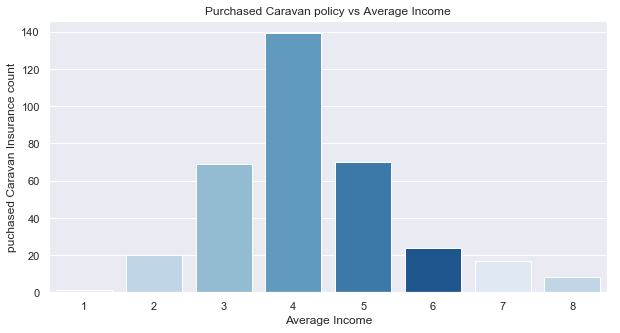

In [15]:
# Purchased caravan policy vs Average Income
purchased_df = caravan_df.loc[caravan_df.CARAVAN == 1]
average_income = purchased_df.loc[:,"MINKGEM"]

# gs = gridspec.GridSpec(2, 2)
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")

# ax = plt.subplot(gs[0,0])
ax = sns.countplot(x=average_income.index,data=average_income,palette=sns.color_palette("Blues"))
ax.set(title="Purchased Caravan policy vs Average Income",xlabel = "Average Income", ylabel="puchased Caravan Insurance count")
plt.show()

#### The most caravan assurance policy holders live in areas where the majority of people have cars

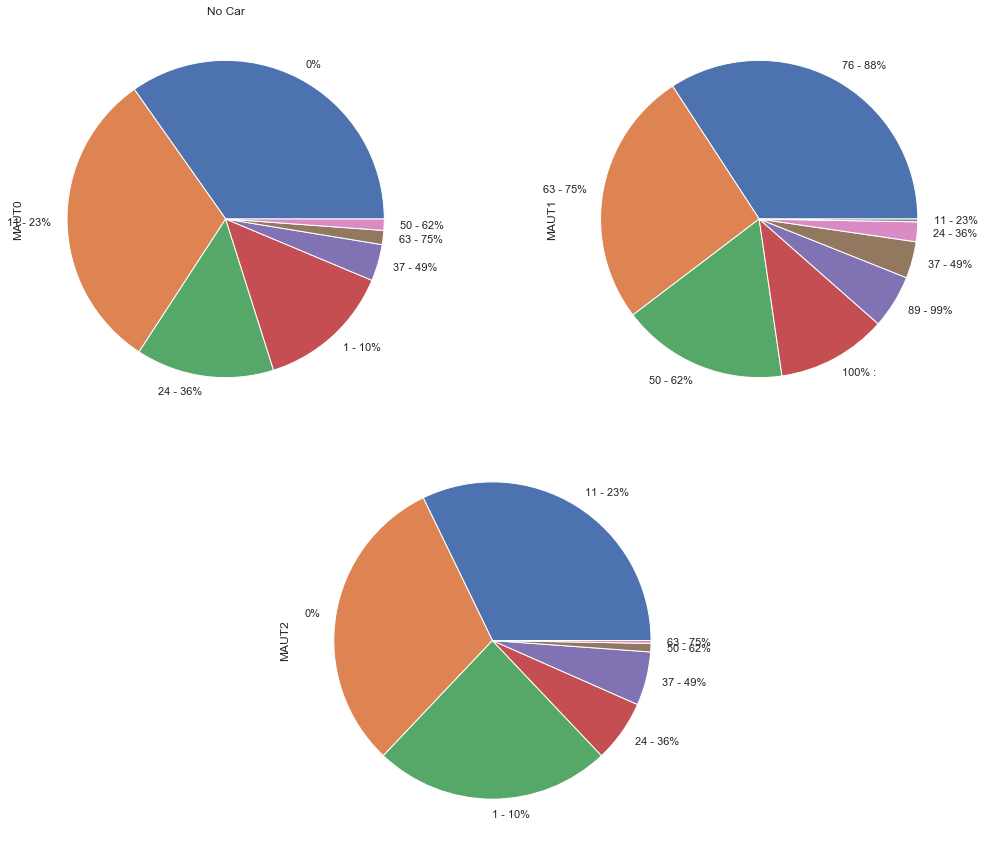

In [16]:
#[32, "MAUT1", "1 car"],
#[33, "MAUT2", "2 cars"]
#[34, "MAUT0", "No car"],
purchased_df = caravan_df.loc[caravan_df.CARAVAN == 1]
gs = gridspec.GridSpec(2, 2)
plt.figure(figsize=(15,12))
percent_values = list(L3_dict.values())

ax = plt.subplot(gs[0,0])
maut0_df =purchased_df.loc[:,"MAUT0"]
maut0 = maut0_df.apply(lambda x: percent_values[x])
maut0.value_counts().plot(kind='pie',ax=ax)
ax.set(title="No Car")

ax1 = plt.subplot(gs[0,1])
maut1_df =purchased_df.loc[:,"MAUT1"]
maut1 = maut1_df.apply(lambda x: percent_values[x])
maut1.value_counts().plot(kind='pie',ax=ax1)

ax2 = plt.subplot(gs[1,:])
maut2_df =purchased_df.loc[:,"MAUT2"]
maut2 = maut2_df.apply(lambda x: percent_values[x])
maut2.value_counts().plot(kind='pie',ax=ax2)

plt.tight_layout()
plt.show()

#The most caravan assurance policy holders live in areas where the majority of people have cars.

#### contributed the most at car policies

<Figure size 720x360 with 0 Axes>

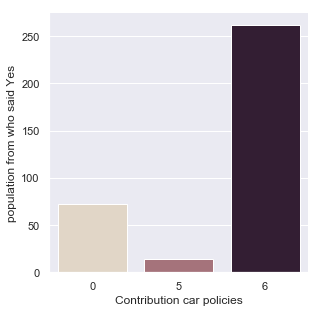

In [17]:
#contribution car policy
purchased_df = caravan_df.loc[caravan_df.CARAVAN == 1]
car_policy = purchased_df.loc[:,"PPERSAUT"]
sns.set(style="darkgrid")
plt.figure(figsize=(10,5))
ax=sns.catplot(x=car_policy.index, kind="count", palette="ch:.25", data=car_policy)
ax.set(xlabel='Contribution car policies', ylabel='population from who said Yes')
plt.show()

# The population who said yes where who contributed the most at car policies

### Prepare Train-Test Split based on outcome

In [18]:
# Shuffle the data randomly. Random seed already set above.
# n= number of iterms returns from axis or / frac= Fraction of item reurn from axis, replace= Sample with or without replaement, 
# weights=None, random_state=None, axis= Axis to sample. Accepts axis number or name.

shuffled_df = caravan_df.sample(frac=1,random_state=np.random.seed(9)).reset_index(drop=True)

# Check the size of dataset is same or not
shuffled_df.shape

(5822, 86)

In [19]:
# Take a look at the count of imbalance dataset.
shuffled_df.CARAVAN.value_counts()

0    5474
1     348
Name: CARAVAN, dtype: int64

In [20]:
# Get the ratio of 1's and 0's
# We want our training and test data to respect the imbalance in our dataset with with respect to the outcome variable's 
# value. We'll do an 80%/20% split, with 80% for training and 20% for test.
# ratio =  Number of Purchased Caravan Insurace / (Number of Purchased + Number of UnPurchased Insurance)
ratio_ones = shuffled_df.CARAVAN.value_counts()[1]/(shuffled_df.CARAVAN.value_counts()[0] + 
                                                    shuffled_df.CARAVAN.value_counts()[1])


In [21]:
# Get size of training and test sets.
train_size = int(shuffled_df.shape[0]*.80)
test_size = shuffled_df.shape[0]-train_size
print('Training set size: %i' % train_size)
print('Test set size: %i' % test_size)

Training set size: 4657
Test set size: 1165


In [22]:
# Get number of 1s and 0s in Purchase column for training set.
train_num_ones = math.ceil(train_size*(ratio_ones))
train_num_zeros = train_size-train_num_ones
print('Training set 1s: %i' % train_num_ones)
print('Training set 0s: %i' % train_num_zeros)

Training set 1s: 279
Training set 0s: 4378


In [23]:
# Get number of 1s and 0s in Purchase column for test set.
test_num_ones = int(test_size*(ratio_ones))
test_num_zeros = test_size-test_num_ones
print('Test set 1s: %i' % test_num_ones)
print('Test set 0s: %i' % test_num_zeros)

Test set 1s: 69
Test set 0s: 1096


In [24]:
# Split shuffled data according to the proper ratios.
test_df = shuffled_df[shuffled_df.CARAVAN == 1][:test_num_ones]
train_df = shuffled_df[shuffled_df.CARAVAN == 1][test_num_ones:]
test_df = test_df.append(shuffled_df[shuffled_df.CARAVAN == 0][:test_num_zeros])
train_df = train_df.append(shuffled_df[shuffled_df.CARAVAN == 0][test_num_zeros:])

In [25]:
# Checking the split is successful or not
# Verify that the split went according to plan.
print(train_df.CARAVAN.value_counts())
print(test_df.CARAVAN.value_counts())

0    4378
1     279
Name: CARAVAN, dtype: int64
0    1096
1      69
Name: CARAVAN, dtype: int64


In [26]:
# Reset training and test DataFrame indexes.
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [27]:
# Split Training set into features X and label y.
y_train = train_df['CARAVAN'].values
X_train = train_df.drop(['CARAVAN'], axis=1).values

In [28]:
# Split test set into features X and label y.
y_test = test_df['CARAVAN'].values
X_test = test_df.drop(['CARAVAN'], axis=1).values

### Classification

**Logistic Regression**

In [29]:
def logistic_regression(X_train,y_train,X_test,y_test,params=None):
    # Classify using Logistic Regression
    lgr = LogisticRegression()
    if params is None:
        parameters={'solver': ['newton-cg','lbfgs','liblinear','sag']}
    else:
        parameters=params
    clf_lgr = GridSearchCV(lgr,parameters,cv=10)
    fit = clf_lgr.fit(X_train,y_train)    
    print(fit)
    # Find the best of our logistic regression models
    best_lgr = clf_lgr.best_estimator_
    print("\nBest Logistic Regression: ")
    print(best_lgr)
    # Make predictions based on our model
    y_hat_lgr = best_lgr.predict(X_test)
    # Examine confusion matrix for logistic regression model
    cm = confusion_matrix(y_test, y_hat_lgr, labels=[1,0])
    print("\n{}".format(cm))
    plot_confusion_matrix(cm)
    # Get ROC curve and AUC.
    y_hat_proba = best_lgr.predict_proba(X_test)
    #Get 
    lgr_fpr, lgr_tpr, thresholds = roc_curve(y_test, y_hat_proba[:,1])
    # Plot ROC curve and AUC for our logistic regression model.
    plot_roc_curve('Logistic Regression ROC Curve',lgr_fpr,lgr_tpr)
    # Examine other metrics.
    print(classification_report(y_test, y_hat_lgr))

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best Logistic Regression: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_

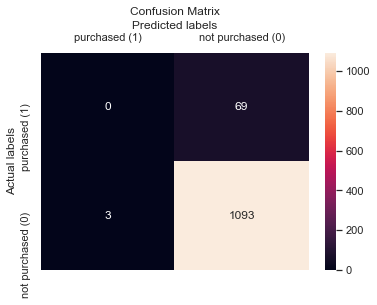

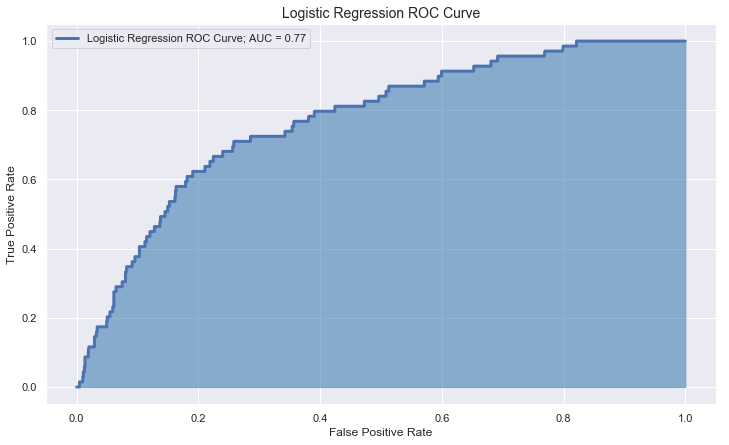

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.88      0.94      0.91      1165



In [30]:
logistic_regression(X_train,y_train,X_test,y_test)

In [31]:
# tn, fp, fn, tp = confusion_matrix(y_test, y_hat_lr).ravel()
# cm = np.array([[tp,fp],[fn,tn]])
# print(cm)
# print("True Positive: {},False Positive: {},False Negative: {}, True Negative: {}".format(tp,fp,fn,tn))

Since we want to correctly classify the purchased (1's) value, we can see that our model is giving very bad result.

Now we are going to take a normal train_test split and try to see how model is doing:

**Train Test split on overall data**

In [32]:
# Now try a non-manual split using train_test_split() and observe
X = shuffled_df.drop(['CARAVAN'], axis=1)
y = shuffled_df['CARAVAN']
X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(X, y, test_size=0.20,random_state=10)

In [33]:
print(y_test_sk.value_counts())
print(y_train_sk.value_counts())

0    1099
1      66
Name: CARAVAN, dtype: int64
0    4375
1     282
Name: CARAVAN, dtype: int64


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best Logistic Regression: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_

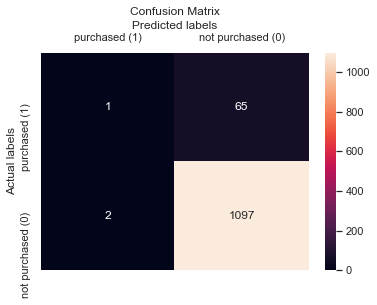

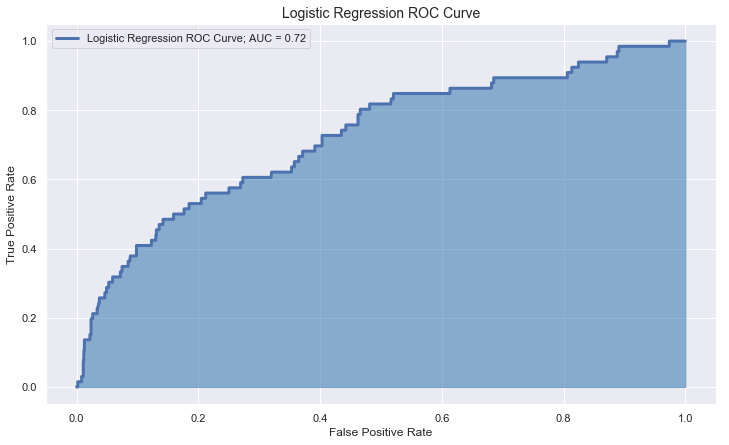

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1099
           1       0.33      0.02      0.03        66

    accuracy                           0.94      1165
   macro avg       0.64      0.51      0.50      1165
weighted avg       0.91      0.94      0.92      1165



In [34]:
# Classify using Logistic Regression and ovserve the results
logistic_regression(X_train_sk,y_train_sk,X_test_sk,y_test_sk)

As we can see still our model isn't doing great. Current model predicts few more 1's and 0's but still is as bad as before. If we take a close look we can see that it predicts almost correctly the not purchased one but our objective is to find those who are potential customers so we need to correctly classify purchased one. Now let's try to run the model with some other classfication model and observe the results.

**Support Vector Classification (SVC)**

In [99]:
def support_vector_classification(X_train,y_train,X_test,y_test,params=None):
    """
    """
    
    if params is None :
        parameters={'C': [0.001,0.01,0.1,0.5,1,2]}
    else:
        parameters = params
    
    clf_svc = GridSearchCV(SVC(kernel='rbf',probability=True),parameters,cv=5,scoring='roc_auc')
    clf_svc.fit(X_train,y_train)
    # find the best SVC models
    best_svc = clf_svc.best_estimator_
    #Make predictions based on our best model
    y_hat_svc = best_svc.predict(X_test)
    #Confusion matrix
    cm = confusion_matrix(y_test,y_hat_svc,labels=[1,0])
    plot_confusion_matrix(cm)
    y_hat_proba_svc= best_svc.predict_proba(X_test)
    svc_fpr,svc_tpr,thresholds = roc_curve(y_test,y_hat_proba_svc[:,1])
    plot_roc_curve('SVC ROC curve',svc_fpr,svc_tpr)
    print("\nClassification Report:\n")
    print(classification_report(y_test,y_hat_svc))

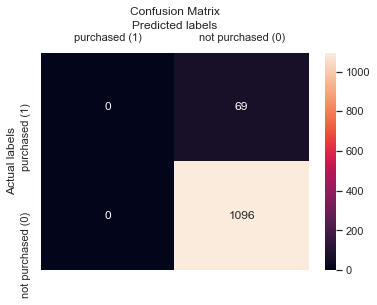

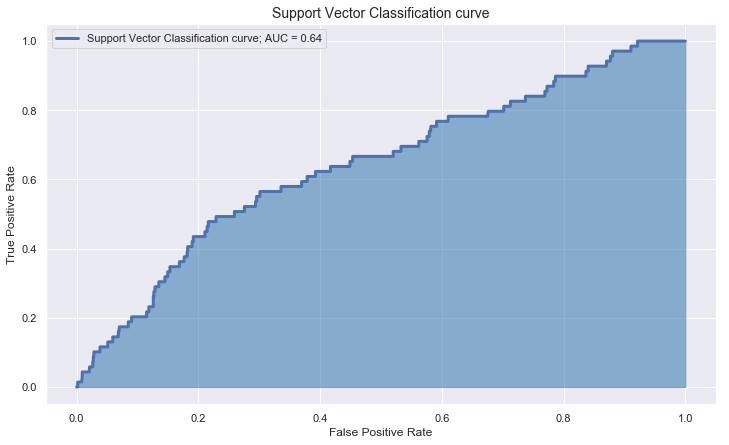


Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.89      0.94      0.91      1165



In [36]:
support_vector_classification(X_train,y_train,X_test,y_test)

**K Nearest Neighbors**

In [174]:
# classify with knn
def k_nearest_neighbors(X_train,y_train,X_test,y_test,params=None):
    if params is None:
        parameters = {'n_neighbors':[2,5,10,20]}
    else:
        parameters = params
        
    knn = KNeighborsClassifier()    
    clf_knn = GridSearchCV(knn,parameters)
    clf_knn.fit(X_train,y_train)
    #Find the best of KNN model
    best_knn = clf_knn.best_estimator_
    #Make predictions based on our best knn model
    y_hat_knn = best_knn.predict(X_test)
    #Examine Confusion matrix for the model    
    cm = confusion_matrix(y_test,y_hat_knn,labels=[1,0])
    plot_confusion_matrix(cm)
    y_hat_proba_knn= best_knn.predict_proba(X_test)
    knn_fpr,knn_tpr,thresholds = roc_curve(y_test,y_hat_proba_knn[:,1])
    plot_roc_curve('K Nearest Neighbors ROC curve',knn_fpr,knn_tpr)
    print("\nClassification Report:\n")
    print(classification_report(y_test,y_hat_knn))
    return best_knn

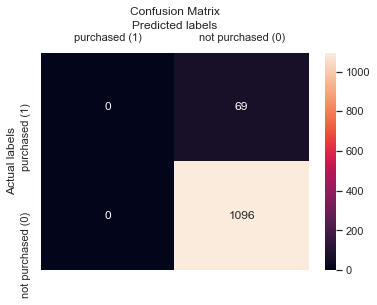

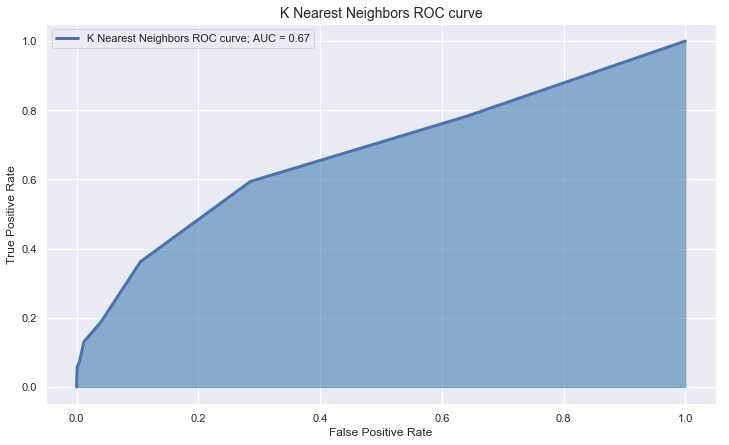


Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.89      0.94      0.91      1165



In [96]:
k_nearest_neighbors(X_train,y_train,X_test,y_test)

We have slightly more correct negative classifications than with Logistic Regression on this dataset but 0 correct positives.
Our classification report as bad as before.Our AUC score is a bit worse as well.

In [100]:
def random_forest(X_train,y_train,X_test,y_test,params=None):
    if params is None:
        parameters = { 'n_estimators': [200, 500],
                       'max_features': ['auto', 'sqrt', 'log2'],
                       'max_depth' : [4,5,6,7,8],
                       'criterion' :['gini', 'entropy']
                     }
    else:
        parameters = params
        
    rndf = RandomForestClassifier()    
    clf_rndf = GridSearchCV(rndf,parameters)
    clf_rndf.fit(X_train,y_train)
    #Find the best of Random Forest model
    best_rndf = clf_rndf.best_estimator_
    #Make predictions based on our best Random Forest model
    y_hat_rndf = best_rndf.predict(X_test)
    #Examine Confusion matrix for the model    
    cm = confusion_matrix(y_test,y_hat_rndf,labels=[1,0])
    plot_confusion_matrix(cm)
    y_hat_proba_rndf= best_rndf.predict_proba(X_test)
    rndf_fpr,rndf_tpr,thresholds = roc_curve(y_test,y_hat_proba_rndf[:,1])
    plot_roc_curve('Ranom Forest ROC curve',rndf_fpr,rndf_tpr)
    print("\nClassification Report:\n")
    print(classification_report(y_test,y_hat_rndf))

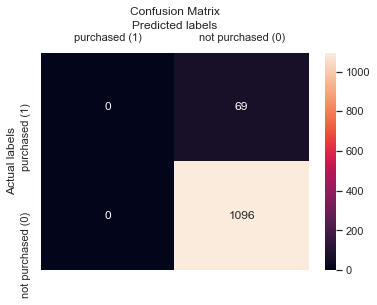

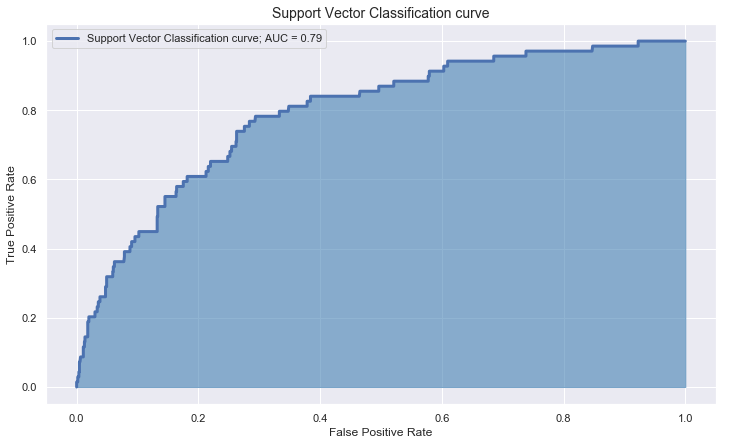


Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.89      0.94      0.91      1165



In [98]:
random_forest(X_train,y_train,X_test,y_test)

 **Run Models with Normalized Data**
 
 Until now we have been working with un-normalized data. Now we will normalize our data and see if our models perform any better.

In [41]:
#Define a scaler for normalizing the data.
scaler = StandardScaler()

In [42]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Now run the models again:

**Logistic Regression**

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best Logistic Regression: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_

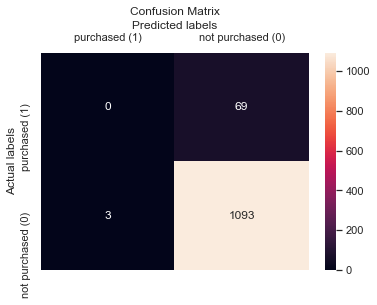

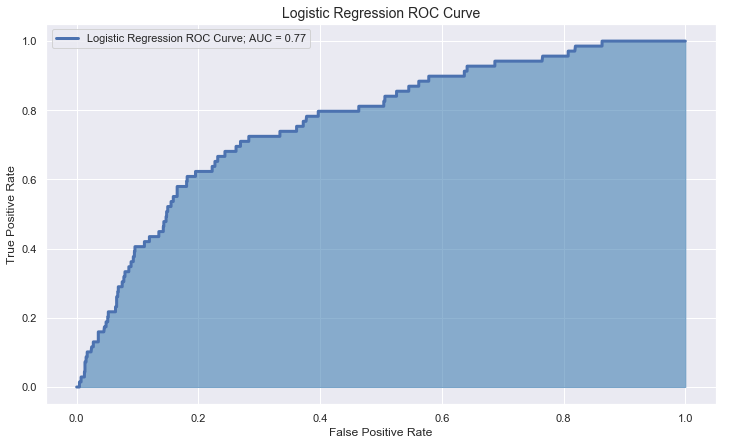

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.88      0.94      0.91      1165



In [43]:
logistic_regression(X_train_scaled,y_train,X_test_scaled,y_test)

This result is same like before.

**SVC**

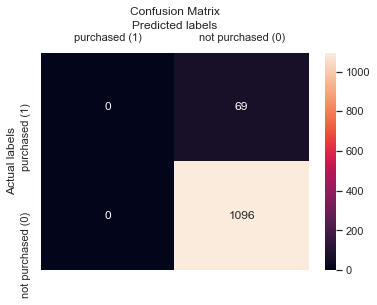

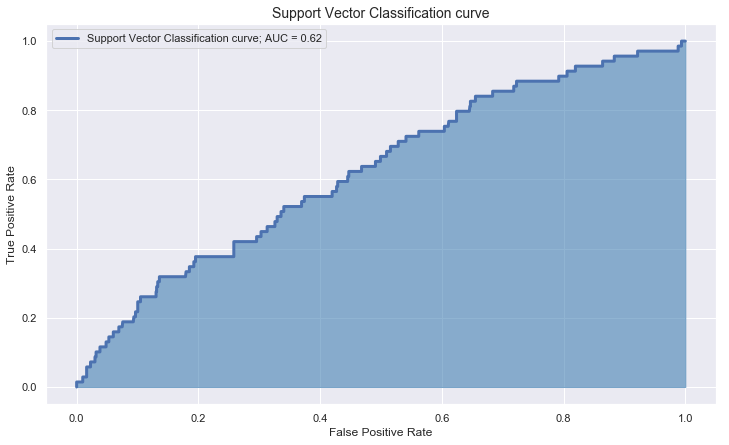


Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.89      0.94      0.91      1165



In [44]:
support_vector_classification(X_train_scaled,y_train,X_test_scaled,y_test)

**KNN**

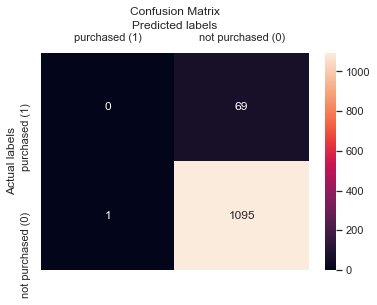

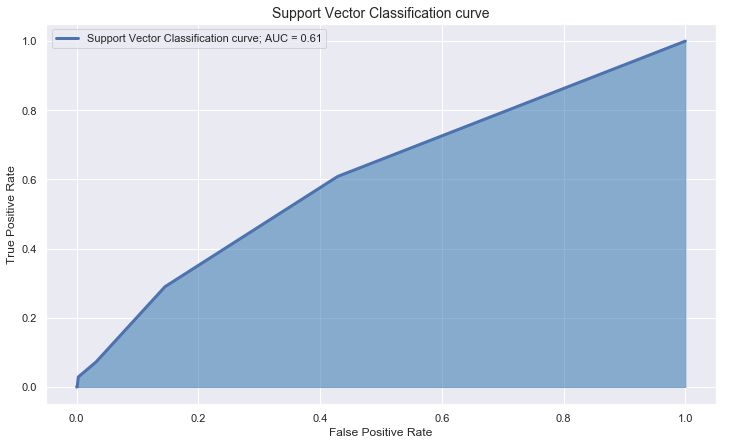


Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.89      0.94      0.91      1165



In [45]:
k_nearest_neighbors(X_train_scaled,y_train,X_test_scaled,y_test)

**Random Forest**

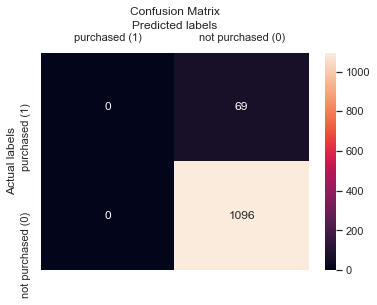

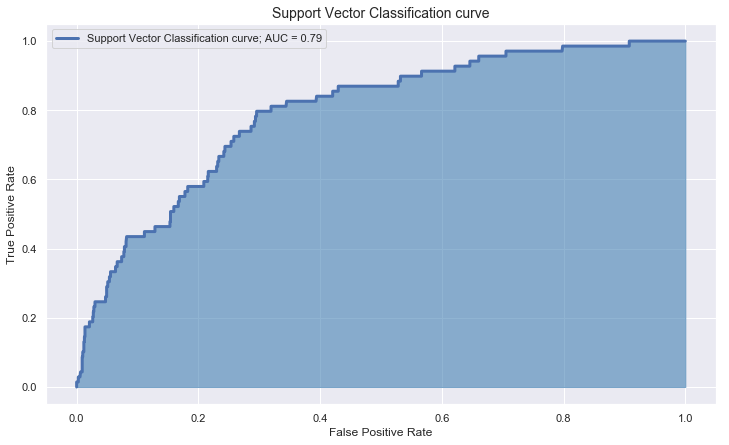


Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.89      0.94      0.91      1165



In [46]:
random_forest(X_train_scaled,y_train,X_test_scaled,y_test)

From the above result we can say that normalized data has no effect in our model. We are not getting any improvement.

**Reduce Class Imbalance**

As we can see that we consistently getting poor results and one reasone could be that our class is imbalanced. In Our 'CARAVAN' or target attribute has 348 positive (1) elements and 5474 negative (0) elements. This can result in a model that tends to more readily classify observations as negatives. Now let's try some sampling technique to improve the results and see what happened

In [47]:
# Remove some negatives using under sampling
undersample_df = caravan_df[caravan_df.CARAVAN == 1]
negative_df = caravan_df[caravan_df.CARAVAN == 0].sample(348).sample(frac=1).reset_index(drop=True)
undersample_df = undersample_df.append(negative_df)

In [48]:
undersample_df.shape

(696, 86)

In [49]:
# Checking that we have an even split for positive and negative.
undersample_df.CARAVAN.value_counts()

1    348
0    348
Name: CARAVAN, dtype: int64

In [50]:
# Split data into X_train and X_test
X_undersample = undersample_df.drop(['CARAVAN'],axis=1).values
y_undersample = undersample_df['CARAVAN'].factorize()[0]

In [51]:
# Normalize the data.
scaler = StandardScaler()
X_scaled_under = scaler.fit_transform(X_undersample)
# Train test split.
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_scaled_under, y_undersample, test_size=0.20, random_state=9)

In [52]:
# y_test_under.shape

D:\Anaconda\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best Logistic Regression: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_

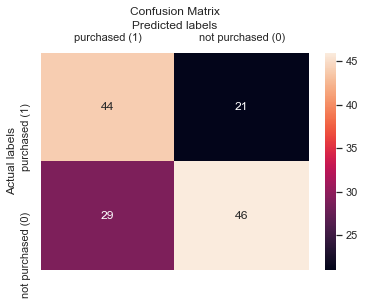

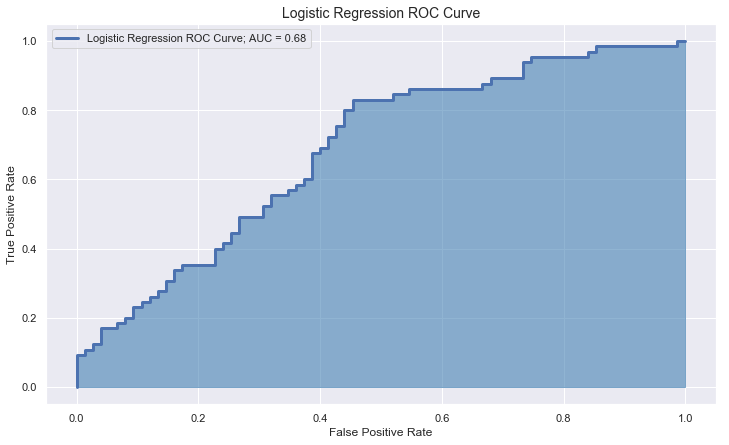

              precision    recall  f1-score   support

           0       0.69      0.61      0.65        75
           1       0.60      0.68      0.64        65

    accuracy                           0.64       140
   macro avg       0.64      0.65      0.64       140
weighted avg       0.65      0.64      0.64       140



In [53]:
logistic_regression(X_train_under,y_train_under,X_test_under,y_test_under)

As we can see we have some progress but not statisfactory. Lets try with some other models

**KNN**

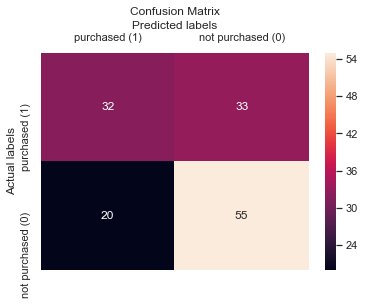

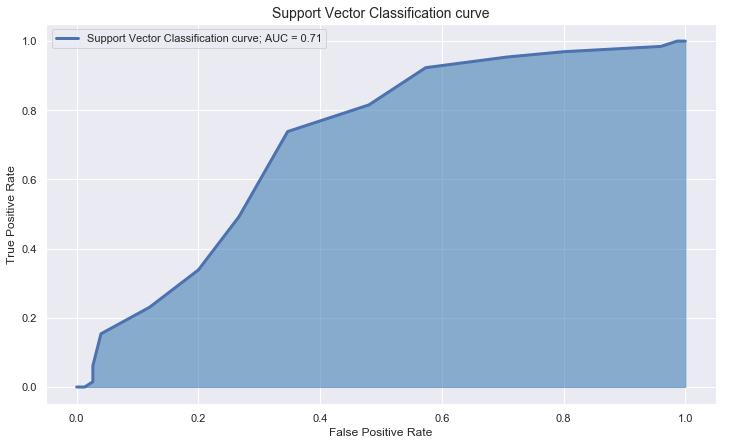


Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.73      0.67        75
           1       0.62      0.49      0.55        65

    accuracy                           0.62       140
   macro avg       0.62      0.61      0.61       140
weighted avg       0.62      0.62      0.62       140



In [57]:
k_nearest_neighbors(X_train_under,y_train_under,X_test_under,y_test_under)

**SVC**

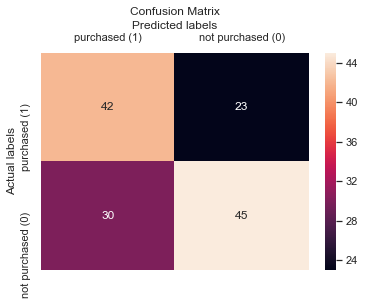

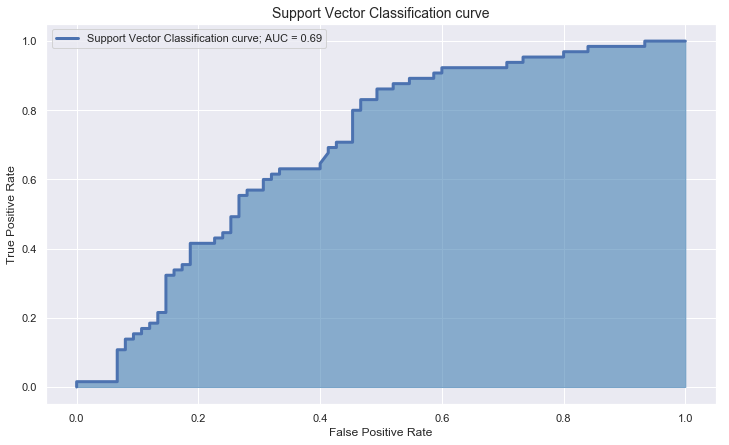


Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.60      0.63        75
           1       0.58      0.65      0.61        65

    accuracy                           0.62       140
   macro avg       0.62      0.62      0.62       140
weighted avg       0.63      0.62      0.62       140



In [58]:
support_vector_classification(X_train_under,y_train_under,X_test_under,y_test_under)

**Random Forest**

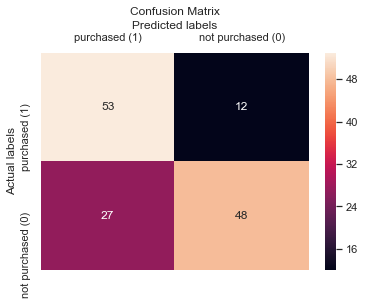

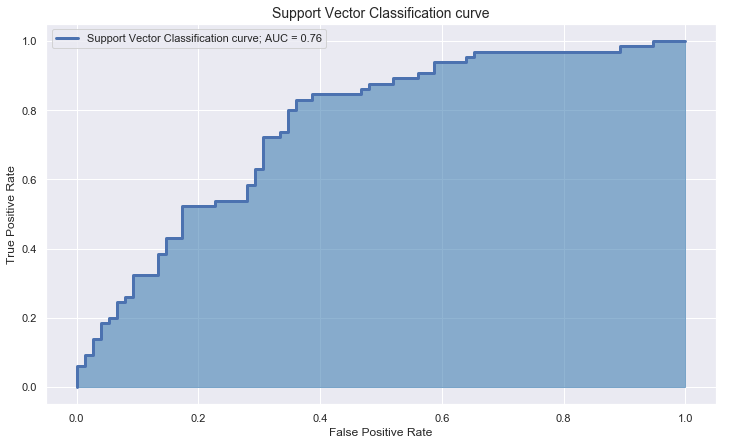


Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.64      0.71        75
           1       0.66      0.82      0.73        65

    accuracy                           0.72       140
   macro avg       0.73      0.73      0.72       140
weighted avg       0.74      0.72      0.72       140



In [60]:
random_forest(X_train_under,y_train_under,X_test_under,y_test_under)

**Over Sampling**

If we take look at the number of positive and negative value then we can see that 5474/348 = 15.7299 or the ratio is almost 1:15. Now let's apply 'oversampling' technique on positive values to get a smaller ratio.

In [64]:
# Append the positive values for multiple times
positives = caravan_df[caravan_df['CARAVAN'] == 1]
for _ in range(4):
    positives = positives.append(caravan_df[caravan_df['CARAVAN'] == 1])

In [65]:
#Check the size
positives.shape

(1740, 86)

In [66]:
#Construct oversample dataframe
oversample_df = caravan_df.append(positives).sample(frac=1).reset_index(drop=True)

In [69]:
oversample_df.shape

(7562, 86)

In [71]:
oversample_df.CARAVAN.value_counts()

0    5474
1    2088
Name: CARAVAN, dtype: int64

In [86]:
#Split the data into X and y
X_oversample = oversample_df.drop(['CARAVAN'],axis=1).values
y_oversample = oversample_df['CARAVAN'].values

In [87]:
# Normalize the data
scaler = StandardScaler()
X_scaled_oversample = scaler.fit_transform(X_oversample)

In [89]:
# train test split
X_train_over,X_test_over,y_train_over,y_test_over = train_test_split(X_scaled_oversample,y_oversample,test_size=0.2,random_state=9)

**Let's evaluate the models again**

**Logistic Regression**

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best Logistic Regression: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_

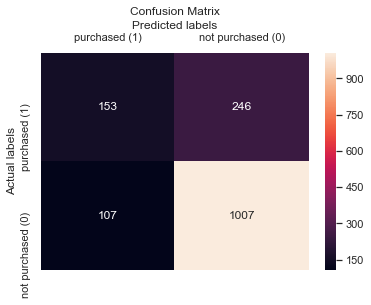

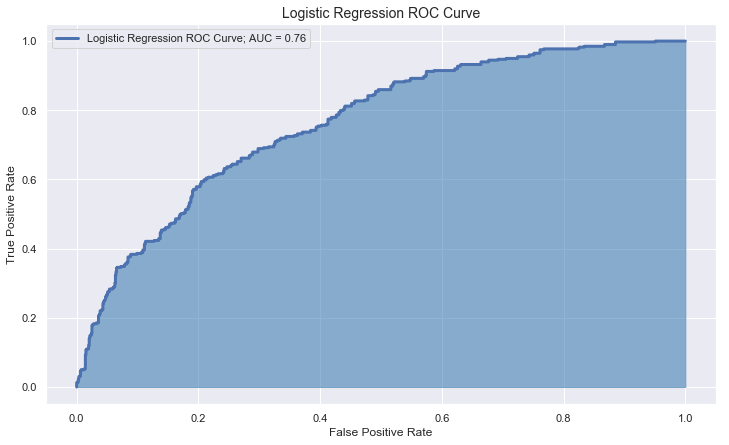

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1114
           1       0.59      0.38      0.46       399

    accuracy                           0.77      1513
   macro avg       0.70      0.64      0.66      1513
weighted avg       0.75      0.77      0.75      1513



In [90]:
logistic_regression(X_train_over,y_train_over,X_test_over,y_test_over)

**SVC**

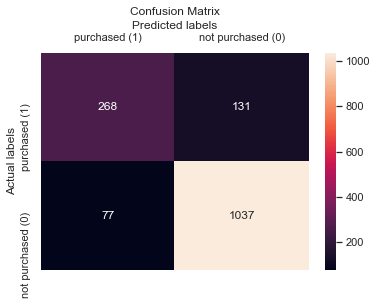

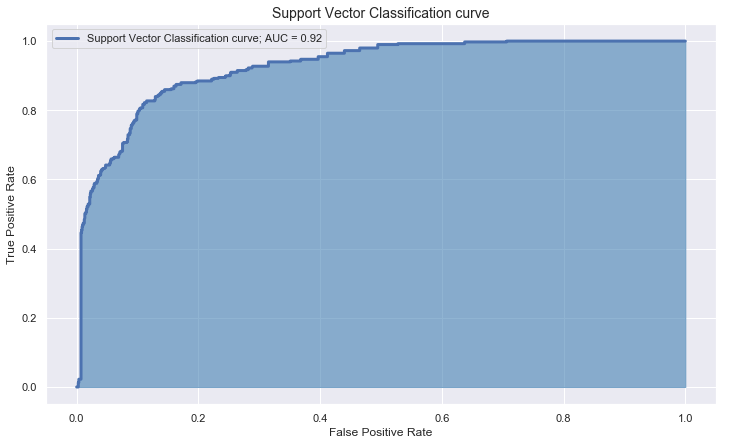


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1114
           1       0.78      0.67      0.72       399

    accuracy                           0.86      1513
   macro avg       0.83      0.80      0.81      1513
weighted avg       0.86      0.86      0.86      1513



In [91]:
support_vector_classification(X_train_over,y_train_over,X_test_over,y_test_over)

This model gives us a good precision numbers on the positive class and our AUC is good.

Try with other model and see what happend:

**KNN**

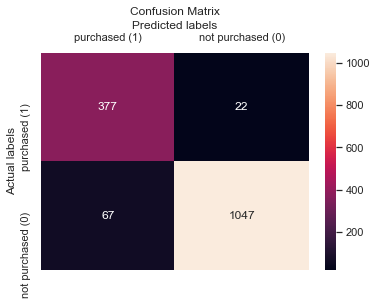

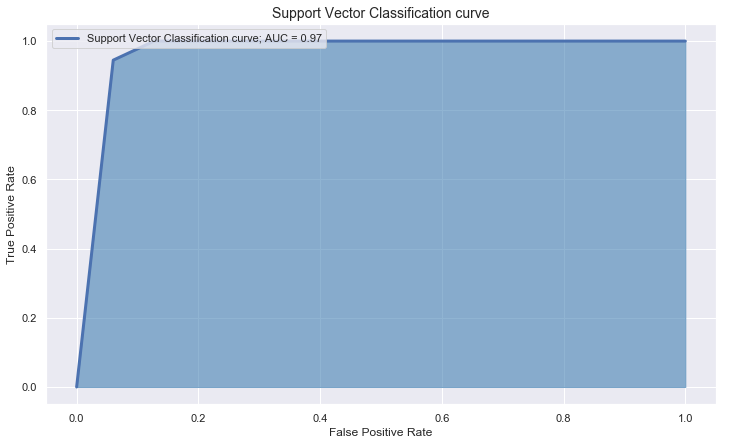


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1114
           1       0.85      0.94      0.89       399

    accuracy                           0.94      1513
   macro avg       0.91      0.94      0.93      1513
weighted avg       0.95      0.94      0.94      1513



In [92]:
k_nearest_neighbors(X_train_over,y_train_over,X_test_over,y_test_over)

**Random Forest**

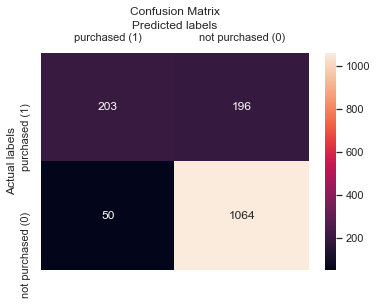

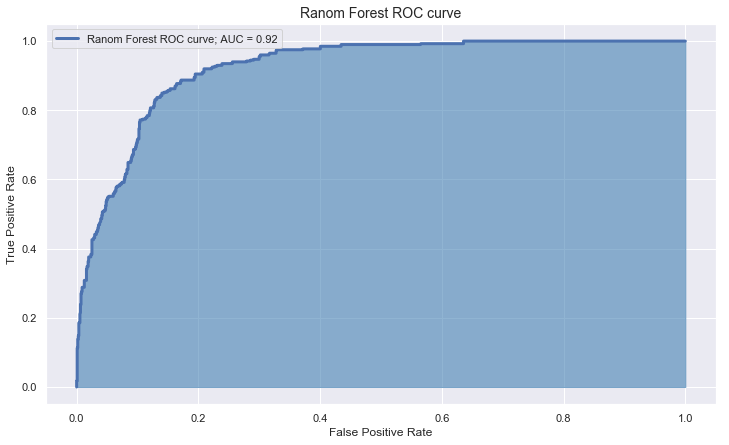


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1114
           1       0.80      0.51      0.62       399

    accuracy                           0.84      1513
   macro avg       0.82      0.73      0.76      1513
weighted avg       0.83      0.84      0.82      1513



In [101]:
random_forest(X_train_over,y_train_over,X_test_over,y_test_over)

In [102]:
caravan_df_smote = caravan_df.sample(frac=1).reset_index(drop=True)
#split data into X and y
X_smote = caravan_df_smote.drop('CARAVAN',axis=1).values
y_smote= caravan_df_smote.CARAVAN.values

#Normalize the data
scaler = StandardScaler()
X_smote_scaled = scaler.fit_transform(X_smote)
#Train Test Split
X_train_smote,X_test_smote,y_train_smote,y_test_smote = train_test_split(X_smote_scaled,y_smote,test_size=0.20,random_state=9)

In [103]:
#Apply SMOTE
sm = SMOTE(random_state=9)
smote_X,smote_y = sm.fit_sample(X_train_smote,y_train_smote)

**Logistic Regression**

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best Logistic Regression: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_

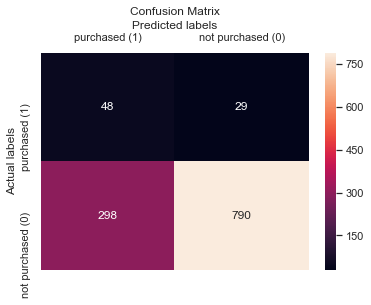

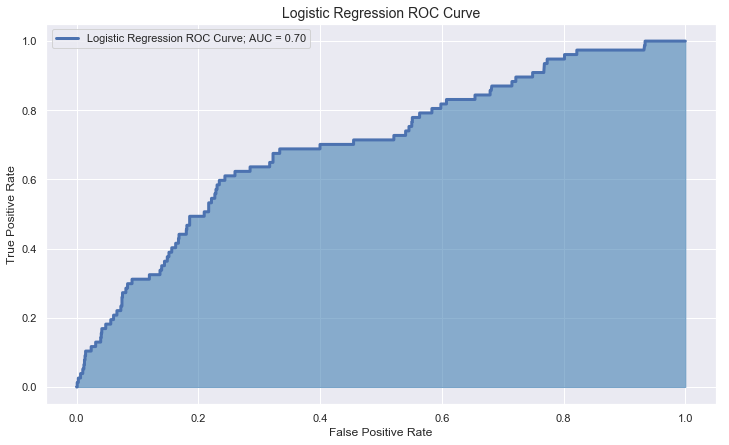

              precision    recall  f1-score   support

           0       0.96      0.73      0.83      1088
           1       0.14      0.62      0.23        77

    accuracy                           0.72      1165
   macro avg       0.55      0.67      0.53      1165
weighted avg       0.91      0.72      0.79      1165



In [104]:
logistic_regression(smote_X,smote_y,X_test_smote,y_test_smote)

We can see that SMOTE is not doing great.

**SVC**

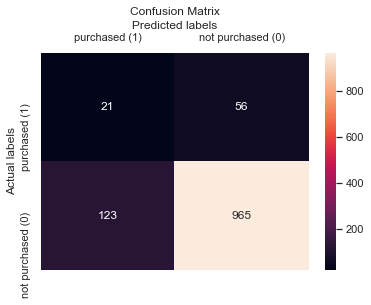

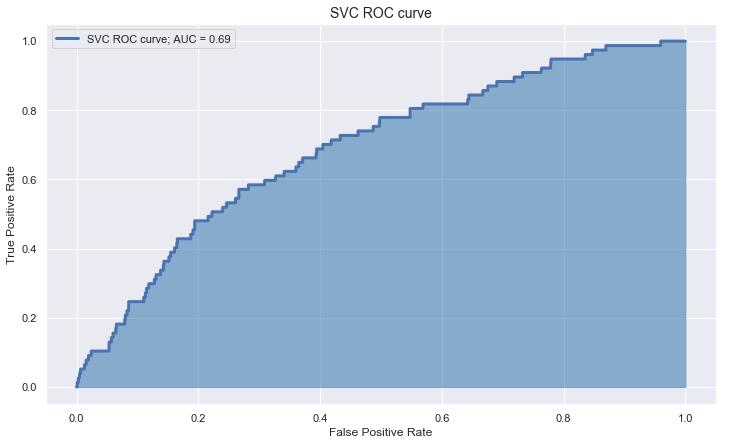


Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1088
           1       0.15      0.27      0.19        77

    accuracy                           0.85      1165
   macro avg       0.55      0.58      0.55      1165
weighted avg       0.89      0.85      0.87      1165



In [105]:
support_vector_classification(smote_X,smote_y,X_test_smote,y_test_smote)

**KNN**

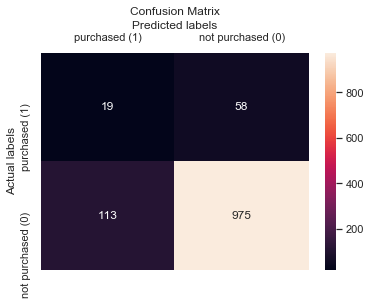

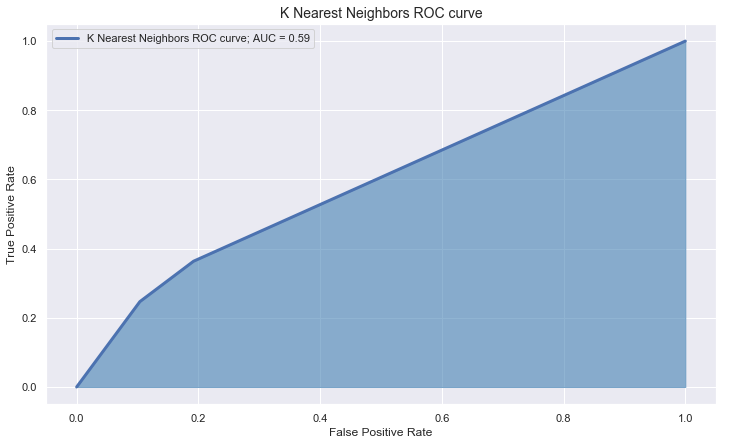


Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1088
           1       0.14      0.25      0.18        77

    accuracy                           0.85      1165
   macro avg       0.54      0.57      0.55      1165
weighted avg       0.89      0.85      0.87      1165



In [108]:
k_nearest_neighbors(smote_X,smote_y,X_test_smote,y_test_smote)

**Random Forest**

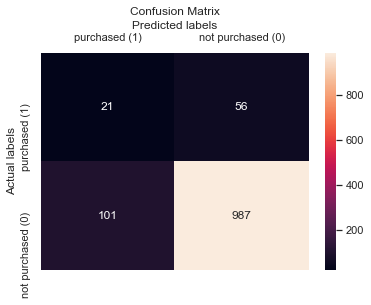

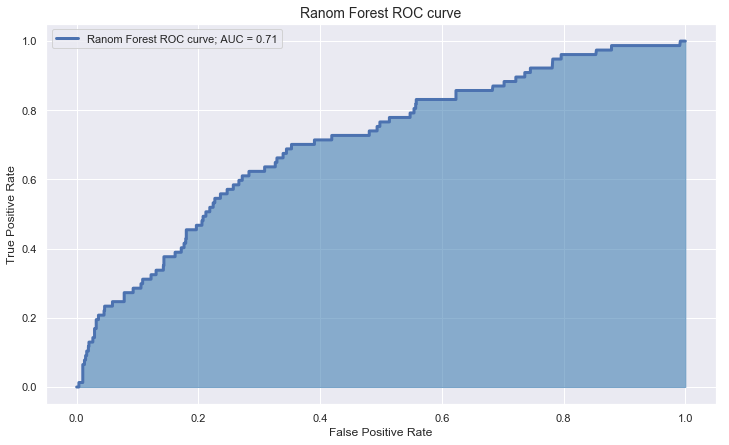


Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1088
           1       0.17      0.27      0.21        77

    accuracy                           0.87      1165
   macro avg       0.56      0.59      0.57      1165
weighted avg       0.90      0.87      0.88      1165



In [106]:
random_forestom_forest(smote_X,smote_y,X_test_smote,y_test_smote)

**Removing Features with Less 'Signal'**

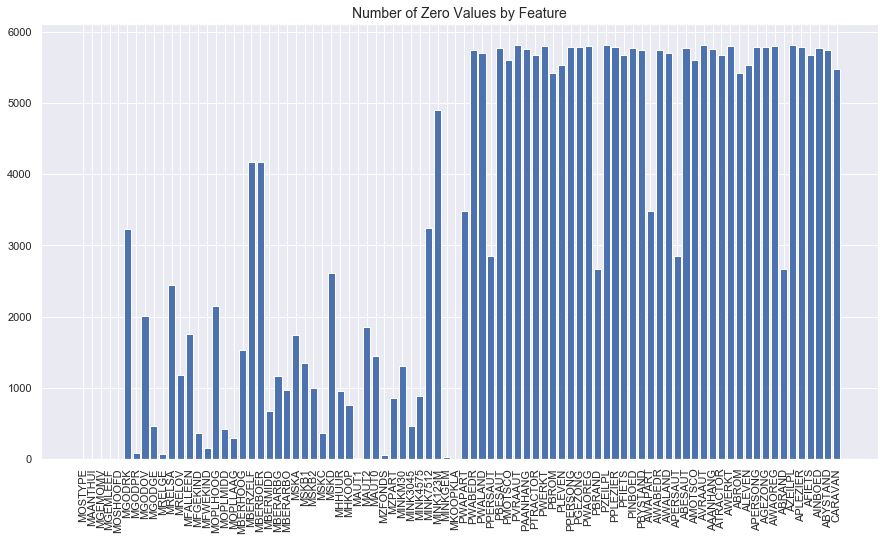

In [121]:
# Recall which features have mostly 0 values.
num_zeros = []
zero_column_list = []
columns = caravan_df.columns
for i in range(0, len(caravan_df.columns)):
    num_nonzero = len(caravan_df.iloc[:,i].nonzero()[0])
    zero_count = caravan_df.shape[0] - num_nonzero
    num_zeros.append(zero_count)
    if zero_count > 5000 and columns[i] != 'CARAVAN':
        zero_column_list.append(columns[i])

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
x_pos = np.arange(len(columns))
ax1 = plt.bar(x_pos, num_zeros)
plt.xticks(x_pos, columns,rotation=90)
plt.title('Number of Zero Values by Feature', size=14)
plt.show()

In [123]:
# Let's drop the feature's that has over 5000's
signal_df = caravan_df.drop(zero_column_list,axis=1)
#Check the size
signal_df.shape

(5822, 50)

Text(0.5, 1.0, 'Number of Zero Values by Feature')

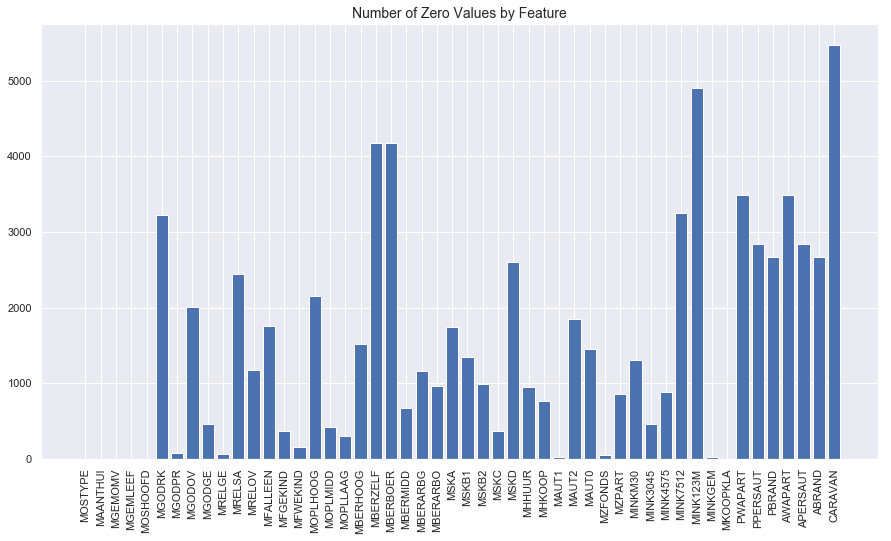

In [124]:
num_zeros = []
columns = signal_df.columns
for i in range(0, len(signal_df.columns)):
    num_nonzero = len(signal_df.iloc[:,i].nonzero()[0])
    zero_count = signal_df.shape[0] - num_nonzero
    num_zeros.append(zero_count)

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
x_pos = np.arange(len(columns))
ax1 = plt.bar(x_pos, num_zeros)
plt.xticks(x_pos, columns,rotation=90)
plt.title('Number of Zero Values by Feature', size=14)

**Ratio-Preserved Training and Test Data based on target value**

In [125]:
# Shuffle the data randomly. Random seed already set above.
shuffled_signal = signal_df.sample(frac=1).reset_index(drop=True)

In [126]:
# Get ratio of 1s to 0s.
ratio_ones = shuffled_signal['CARAVAN'].value_counts()[1]/(shuffled_signal['CARAVAN'].value_counts()[0] + 
                                                        shuffled_signal['CARAVAN'].value_counts()[1])

In [127]:
# Get size of training and test sets.
train_size = int(shuffled_signal.shape[0]*.80)
test_size = shuffled_signal.shape[0]-train_size
print('Training set size: %i' % train_size)
print('Test set size: %i' % test_size)

Training set size: 4657
Test set size: 1165


In [128]:
# Get number of 1s and 0s in CARAVAN column for training set.
train_num_ones = math.ceil(train_size*(ratio_ones))
train_num_zeros = train_size-train_num_ones
print('Training set 1s: %i' % train_num_ones)
print('Training set 0s: %i' % train_num_zeros)

Training set 1s: 279
Training set 0s: 4378


In [130]:
# Split shuffled data according to the proper ratios.
test_signal = shuffled_signal[shuffled_signal.CARAVAN == 1][:test_num_ones]
train_signal = shuffled_signal[shuffled_signal.CARAVAN == 1][test_num_ones:]
test_signal = test_signal.append(shuffled_signal[shuffled_signal.CARAVAN == 0][:test_num_zeros])
train_signal = test_signal.append(shuffled_signal[shuffled_signal.CARAVAN == 0][test_num_zeros:])

# Verify that the split went according to plan.
print(test_signal['CARAVAN'].value_counts())
print(train_signal['CARAVAN'].value_counts())

0    1096
1      69
Name: CARAVAN, dtype: int64
0    5474
1      69
Name: CARAVAN, dtype: int64


In [132]:
# Reset training and test dataset indexes.
train_signal = train_signal.sample(frac=1).reset_index(drop=True)
test_signal = test_signal.sample(frac=1).reset_index(drop=True)

# Split training set into features X and label y.
y_train_signal = train_signal.CARAVAN
X_train_signal = train_signal.drop(['CARAVAN'], axis=1)

# Split test set into features X and label y.
y_test_signal = test_signal.CARAVAN
X_test_signal = test_signal.drop(['CARAVAN'], axis=1)

# Define a scaler for normalizing the data.
scaler = StandardScaler()

# Get scaled data.
X_train_signal_scaled = scaler.fit_transform(X_train_signal)
X_test_signal_scaled = scaler.transform(X_test_signal)

**Logistic Regression**

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best Logistic Regression: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_

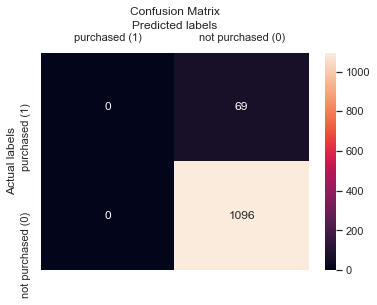

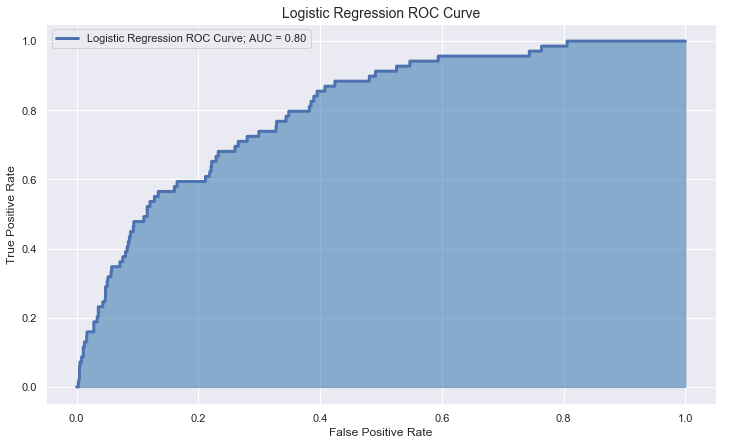

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.89      0.94      0.91      1165



In [133]:
logistic_regression(X_train_signal_scaled,y_train_signal,X_test_signal_scaled,y_test_signal)

**SVC**

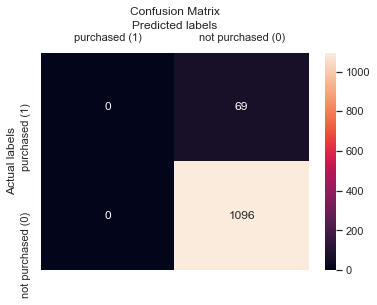

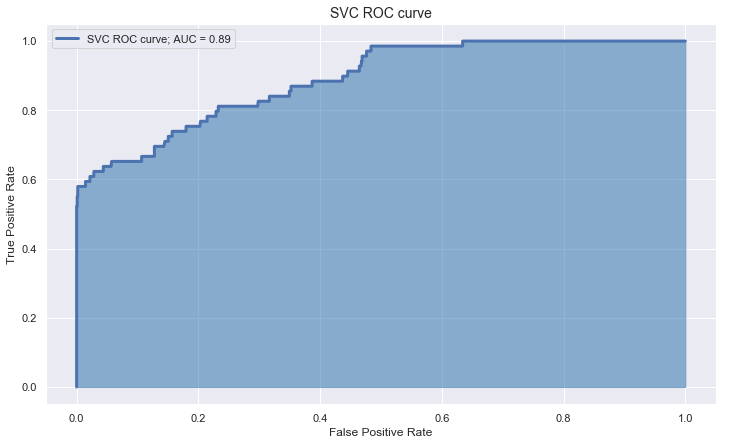


Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.89      0.94      0.91      1165



In [134]:
support_vector_classification(X_train_signal_scaled,y_train_signal,X_test_signal_scaled,y_test_signal)

**KNN**

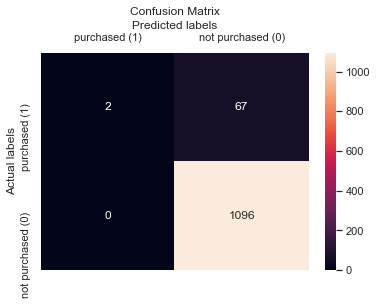

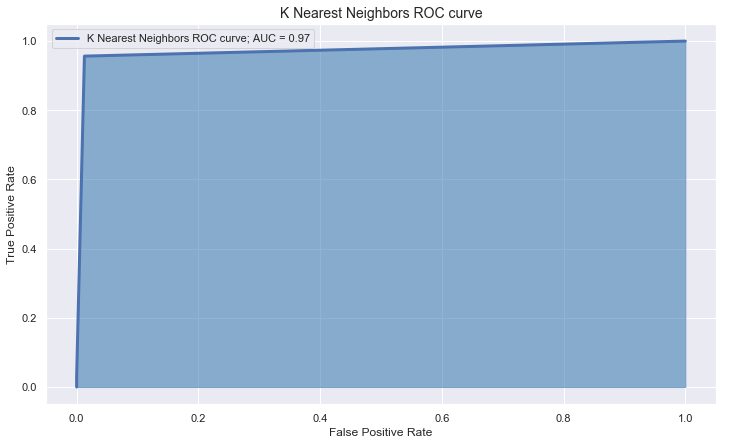


Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       1.00      0.03      0.06        69

    accuracy                           0.94      1165
   macro avg       0.97      0.51      0.51      1165
weighted avg       0.95      0.94      0.92      1165



In [142]:
k_nearest_neighbors(X_train_signal_scaled,y_train_signal,X_test_signal_scaled,y_test_signal)

As we can see this model gives us good precision as well as good auc result but If we take a look at the Confusion matrix and the recall score then we will clearly understand that this model is as bad as before.

**Random Forest**

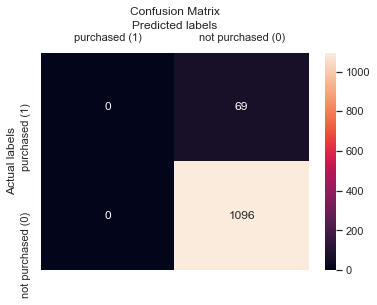

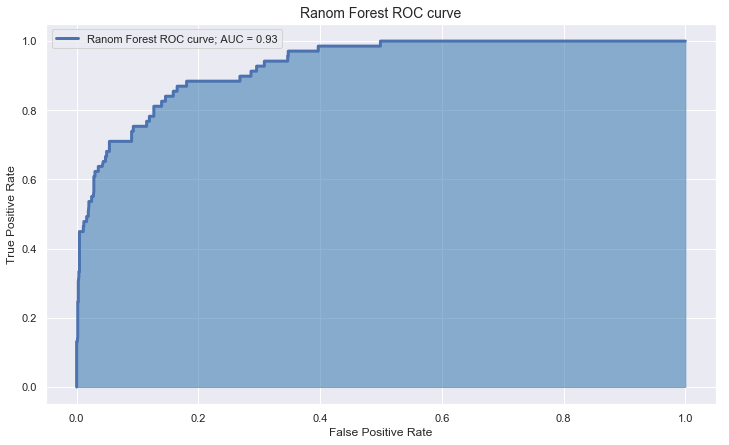


Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1096
           1       0.00      0.00      0.00        69

    accuracy                           0.94      1165
   macro avg       0.47      0.50      0.48      1165
weighted avg       0.89      0.94      0.91      1165



In [136]:
random_forest(X_train_signal_scaled,y_train_signal,X_test_signal_scaled,y_test_signal)

**Over Sampling with reduced features (After dropping features that has zero signal more than 5000)**

As we can see our AUC is improved but it did not improve our predictive power for the positive class.
Let's implement fewe features with over sampling and see what happened

In [166]:
# Multiply the number of positives by 6. We'll then add to the original database for 7x total positives.
positives = signal_df[signal_df.CARAVAN == 1]
for _ in range(4):
    positives = positives.append(signal_df[signal_df.CARAVAN == 1])

# Append negatives.
oversample_signal_df = signal_df.append(positives).sample(frac=1).reset_index(drop=True)

# Check size of new dataset.
print(oversample_signal_df.shape)

# Check ratio of label values.
oversample_signal_df.CARAVAN.value_counts()

(7562, 50)


0    5474
1    2088
Name: CARAVAN, dtype: int64

In [169]:
# Split data into X and y.
X_signal_over = oversample_signal_df.drop(['CARAVAN'], axis=1).values
y_signal_over = oversample_signal_df['CARAVAN'].values

# Normalize the data.
scaler = StandardScaler()
X_signal_scaled_over = scaler.fit_transform(X_signal_over)

# Train test split.
X_train_ss_over, X_test_ss_over, y_train_ss_over, y_test_ss_over = train_test_split(X_signal_scaled_over, y_signal_over, 
                                                                                    test_size=0.20, random_state=9)

**Logistic Regression**

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best Logistic Regression: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_

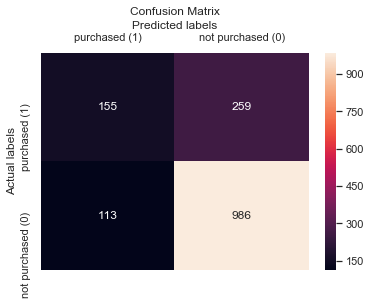

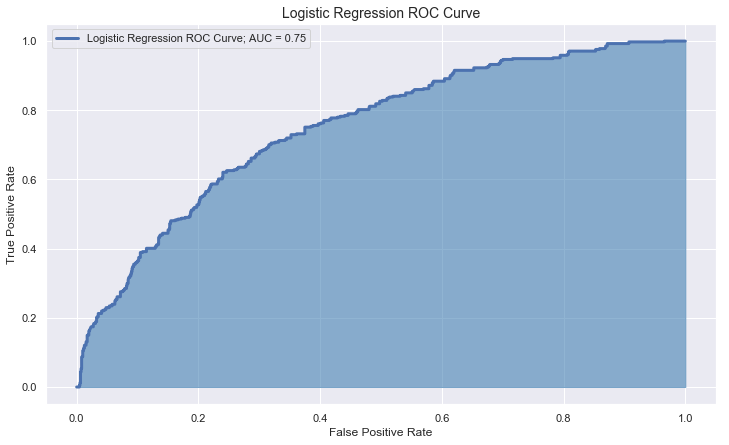

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1099
           1       0.58      0.37      0.45       414

    accuracy                           0.75      1513
   macro avg       0.69      0.64      0.65      1513
weighted avg       0.73      0.75      0.74      1513



In [170]:
logistic_regression(X_train_ss_over,y_train_ss_over,X_test_ss_over,y_test_ss_over)

**SVC**

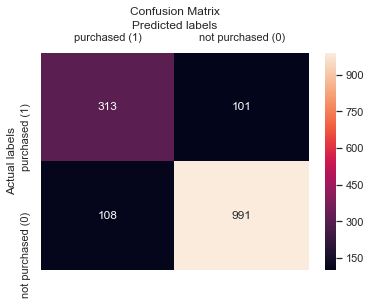

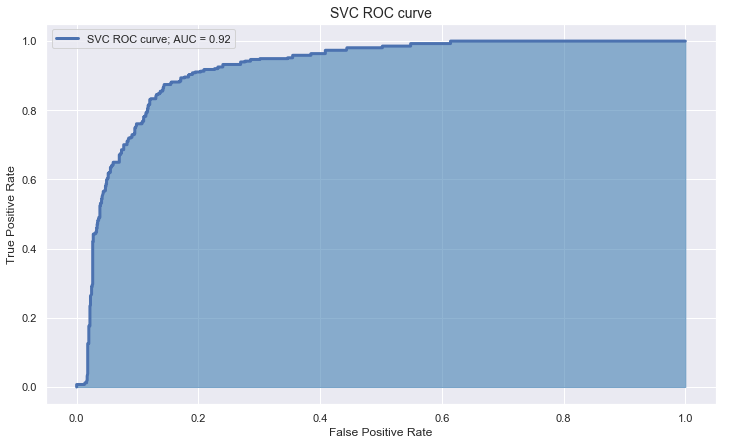


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1099
           1       0.74      0.76      0.75       414

    accuracy                           0.86      1513
   macro avg       0.83      0.83      0.83      1513
weighted avg       0.86      0.86      0.86      1513



In [171]:
support_vector_classification(X_train_ss_over,y_train_ss_over,X_test_ss_over,y_test_ss_over)

**KNN**

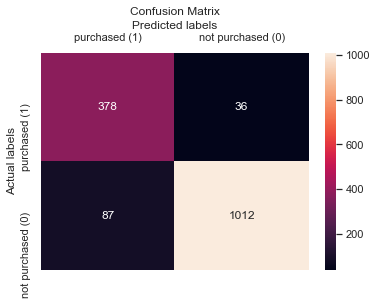

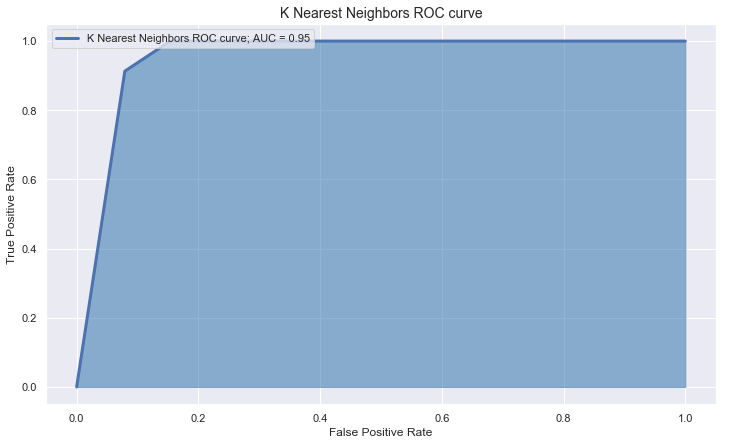


Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1099
           1       0.81      0.91      0.86       414

    accuracy                           0.92      1513
   macro avg       0.89      0.92      0.90      1513
weighted avg       0.92      0.92      0.92      1513



In [175]:
best_knn = k_nearest_neighbors(X_train_ss_over,y_train_ss_over,X_test_ss_over,y_test_ss_over)

**Random Forest**

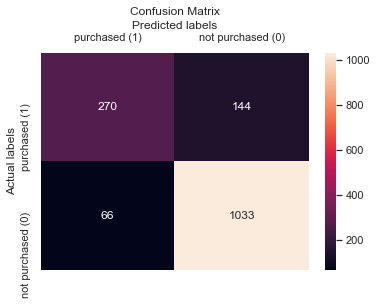

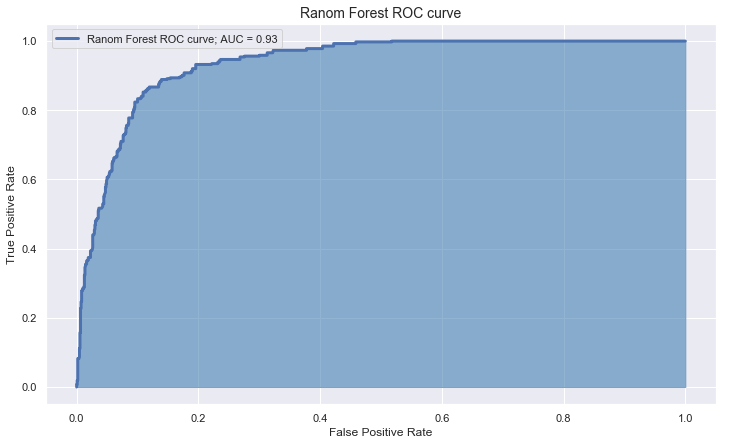


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1099
           1       0.80      0.65      0.72       414

    accuracy                           0.86      1513
   macro avg       0.84      0.80      0.81      1513
weighted avg       0.86      0.86      0.86      1513



In [173]:
random_forest(X_train_ss_over,y_train_ss_over,X_test_ss_over,y_test_ss_over)

### Run with Test set

In [197]:
# Make Data Frame, Readibng the column names from list
columns = [i[1] for i in data_list]
# indices = [i for i, s in enumerate(columns) if s in zero_column_list]
columns = columns[:-1]
test_df = construct_df(test_data,columns)



In [200]:
test_df = test_df.drop(zero_column_list,axis=1)

In [203]:
y_hat_knn = best_knn.predict(test_df.values)


In [206]:
np.count_nonzero(y_hat_knn)

382